In [1]:
%matplotlib inline

In [2]:
import numpy as np
# import tensorflow as tf
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from server import fake_connection
import cv2

Gather the contour points according to a min and max thresh for the area of contours.

In [3]:
THRESH1 = 96
THRESH2 = 140
CONTOUR_MIN = 756
CONTOUR_MAX = 2277

frame_width = None
frame_hight = None

gathering_points = True
all_contours = None
max_points = 100000

# While number of points collects is insufficient
while gathering_points:
    for frame in fake_connection():

        # Saved frame dimensions
        if frame_width is None:
            frame_height, frame_width, _ = frame.shape

        # Apply open cv2 image transmformations for contour detection
        blurred = cv2.GaussianBlur(frame, (7, 7), 2)
        gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
        canny = cv2.Canny(gray, THRESH1, THRESH2)
        kernel = np.ones((5,5))
        dilated = cv2.dilate(canny, kernel, iterations=1)
        contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        for contour in contours:

            # Filter by min and max areas of contours
            area = cv2.contourArea(contour)
            if area > CONTOUR_MIN and area < CONTOUR_MAX:

                # Init np.array for all_contours
                if all_contours is None: all_contours = np.array(contour)

                else:
                    if len(all_contours) >= max_points:
                        gathering_points = False
                        break
                    
                    else:
                        all_contours = np.append(all_contours, contour, axis=0)
        
        if not gathering_points: break

drawable = all_contours
all_contours = all_contours.reshape((-1, 2))

Given the list of all points gathered, perform Kmeans clustering

In [7]:
def find_closest_centroid(X, centroids):

    K = centroids.shape[0]
    m, n = X.shape

    indices = np.zeros(m, dtype=int)

    # For each point
    for i in range(m):
        distances = []

        # For each centroids
        for j in range(K):

            # Calc distance
            norm = np.linalg.norm(X[i] - centroids[j], axis=0)
            distances.append(norm)

        # Save min distance to current point
        indices[i] = np.argmin(distances)

    return indices

def update_centroid(X, indicies, K):
    m, n = X.shape
    new_centroids = []

    # For each centroid
    for k in range(K):

        # Find all points bound to the current centroid
        points = X[indicies==k]

        # If there is at least one point
        if len(points) != 0:
            new_centroids.append(np.mean(points, axis=0))
    return np.array(new_centroids)

centroids = []
width_bins = 4
height_bins = 4
x_diff = frame_width // width_bins
y_diff = frame_height // height_bins
curr_y = y_diff
for _ in range(height_bins-1):
    curr_x = x_diff
    for _ in range(width_bins-1):
        centroids.append([curr_x, curr_y])
        curr_x += x_diff
    curr_y += y_diff
centroids = np.array(centroids)

history = []
m, n = all_contours.shape


indicies = np.zeros(m)
max_iter = 5

for i in range(max_iter):
    K = len(centroids)
    print(f"\n\nK-Means Iteration ({i}) / ({max_iter})")
    indicies = find_closest_centroid(all_contours, centroids)
    # print(np.unique(indicies))
    history.append(centroids)
    centroids = update_centroid(all_contours, indicies, K)




K-Means Iteration (0) / (5)


K-Means Iteration (1) / (5)


K-Means Iteration (2) / (5)


K-Means Iteration (3) / (5)


K-Means Iteration (4) / (5)


Show found centroid positions and contours

Displaying 6 centroids


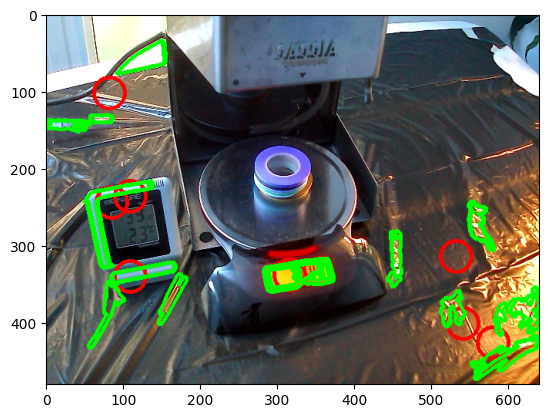

In [8]:

# t = 0
# for _centroids in history:
#     for centroid in _centroids:
#         centroid = tuple(np.uint32(centroid))
#         cv2.circle(frame, centroid, 20, (0, 0, t), 3)
    
#     t += 75

print(f"Displaying {len(centroids)} centroids")

for centroid in centroids:
    centroid = tuple(np.uint32(centroid))
    cv2.circle(frame, centroid, 20, (255, 0, 0), 3)

# cv2.drawContours(frame, drawable, -1, (0, 255, 0), 3)
plt.figure()
plt.imshow(frame)

Go through all sensor guesses (centroids) and check if there they contain digits